In [31]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import re

# todo
- d_model和d_ff对于结果影响大吗

In [32]:
# metric in long-term-forecasting
# mae, mse, rmse, mape, mspe

In [33]:
dataset = 'ETTh1'
pred_lens = [96, 192, 336, 720] if dataset not in ['ili', 'fred-md', 'covid-19'] else [24]
path = '/data/nishome/user1/minqi/TSGym/resultsGym_non_transformer'
path_runtime = '/data/nishome/user1/minqi/TSGym/test_resultsGym_non_transformer'


result_dict, runtime_dict = {}, {}
for pred_len in pred_lens:
    model_list = os.listdir(path)
    model_list = [_ for _ in model_list if f'pl{pred_len}' in _ and dataset in _]
    result_dict[pred_len], runtime_dict[pred_len] = {}, {}
    for model in model_list:
        try:
            result = np.load(os.path.join(path, model, 'metrics.npy'), allow_pickle=True)
            result_dict[pred_len][model] = result[1]
            
            # runtime = np.load(os.path.join(path_runtime, 'custom_Monthly_'+model[model.find('TSGym'): model.find('custom')-1]+'_fit_time_per_epoch.npz'), allow_pickle=True)
            # runtime_dict[pred_len][model] = runtime['time']
        except:
            pass
            continue

In [34]:
for pred_len in pred_lens:
    result_dict[pred_len] = {k: v for k, v in result_dict[pred_len].items() if 'epochs' in k}

# for pred_len in pred_lens:
#     result_dict[pred_len] = {k: v for k, v in result_dict[pred_len].items() if 'dm256' in k and 'df512' in k and 'epochs' not in k}

# for pred_len in pred_lens:
#     result_dict[pred_len] = {k: v for k, v in result_dict[pred_len].items() if 'dm16' in k and 'df64' in k}

In [35]:
df = pd.DataFrame.from_dict(result_dict[96], orient='index') if dataset not in ['ili', 'fred-md', 'covid-19'] else pd.DataFrame.from_dict(result_dict[24], orient='index')
print(df.shape)
df.columns = ['mse']

# df_runtime = pd.DataFrame.from_dict(runtime_dict[96], orient='index')
# df_runtime.columns = ['runtime-per-epoch']

# df = pd.concat([df, df_runtime], axis=1).dropna()
# df = df.loc[[_ for _ in df.index if 'Transformer' in _]]

df.sort_values(by='mse').head(20)
# df.sort_values(by='runtime-per-epoch', ascending=True).head(20)

(7, 1)


,mse
long_term_forecast_ETTh1_96_96_TSGym_False_Stat_DFT_False_series-encoding_MLP_null_self-attention_True_False_ETTh1_ftM_sl512_ll48_pl96_dm256_nh8_el2_dl1_df1024_expand2_dc4_fc3_ebtimeF_dtTrue_Exp_epochs10_lr0.0001_lrstype1_0,0.411554
long_term_forecast_ETTh1_96_96_TSGym_False_DishTS_None_False_series-encoding_MLP_null_self-attention_True_False_ETTh1_ftM_sl512_ll48_pl96_dm64_nh8_el2_dl1_df256_expand2_dc4_fc3_ebtimeF_dtTrue_Exp_epochs10_lr0.001_lrstype1_0,0.470658
long_term_forecast_ETTh1_96_96_TSGym_True_Stat_DFT_False_series-encoding_GRU_null_self-attention_True_False_ETTh1_ftM_sl512_ll48_pl96_dm64_nh8_el3_dl1_df256_expand2_dc4_fc3_ebtimeF_dtTrue_Exp_epochs10_lr0.001_lrstype1_0,0.536883
long_term_forecast_ETTh1_96_96_TSGym_False_DishTS_DFT_False_series-encoding_GRU_null_frequency-enhanced-attention_True_False_ETTh1_ftM_sl512_ll48_pl96_dm64_nh8_el3_dl1_df256_expand2_dc4_fc3_ebtimeF_dtTrue_Exp_epochs10_lr0.0001_lrstype1_0,0.561837
long_term_forecast_ETTh1_96_96_TSGym_False_None_DFT_False_series-encoding_MLP_null_sparse-attention_True_False_ETTh1_ftM_sl512_ll48_pl96_dm256_nh8_el2_dl1_df1024_expand2_dc4_fc3_ebtimeF_dtTrue_Exp_epochs10_lr0.001_lrstype1_0,0.637261
long_term_forecast_ETTh1_96_96_TSGym_False_None_MoEMA_False_series-encoding_MLP_null_frequency-enhanced-attention_True_False_ETTh1_ftM_sl512_ll48_pl96_dm256_nh8_el3_dl1_df1024_expand2_dc4_fc3_ebtimeF_dtTrue_Exp_epochs10_lr0.001_lrstype1_0,0.773494
long_term_forecast_ETTh1_96_96_TSGym_False_DishTS_MA_False_series-encoding_GRU_null_frequency-enhanced-attention_True_False_ETTh1_ftM_sl512_ll48_pl96_dm256_nh8_el2_dl1_df1024_expand2_dc4_fc3_ebtimeF_dtTrue_Exp_epochs10_lr0.001_lrsnull_0,0.780786


In [36]:
# df = pd.DataFrame.from_dict(result_dict[192], orient='index')
# df.columns = ['mse']
# df.sort_values(by='mse').head(20)
# # df.sort_values(by='mse').to_csv('gym_192.csv', index=True)

In [37]:
# df = pd.DataFrame.from_dict(result_dict[336], orient='index')
# df.columns = ['mse']
# df.sort_values(by='mse').head(20)
# # df.sort_values(by='mse').to_csv('gym_336.csv', index=True)

In [38]:
# df = pd.DataFrame.from_dict(result_dict[720], orient='index')
# df.columns = ['mse']
# df.sort_values(by='mse').head(20)
# # df.sort_values(by='mse').to_csv('gym_720.csv', index=True)

In [39]:
# result_dict_vis = result_dict.copy()
# for pred_len in pred_lens:
#     result_dict_vis[pred_len] = {k[k.find('TSGym')+6: k.find('custom')-1]:v for k, v in result_dict_vis[pred_len].items()}

result_dict_vis = result_dict.copy()
for pred_len in pred_lens:
    result_dict_vis[pred_len] = {'_'.join([k[k.find('TSGym')+6: k.find('custom')-1],
                                           re.search(r'sl(\d+)', k)[0],
                                           re.search(r'dm(\d+)', k)[0],
                                           re.search(r'df(\d+)', k)[0],
                                           re.search(r'el(\d+)', k)[0],
                                           re.search(r'epochs(\d+)', k)[0],
                                           re.search(r'lr(\d+\.\d+)', k)[0]]):v for k, v in result_dict_vis[pred_len].items()}

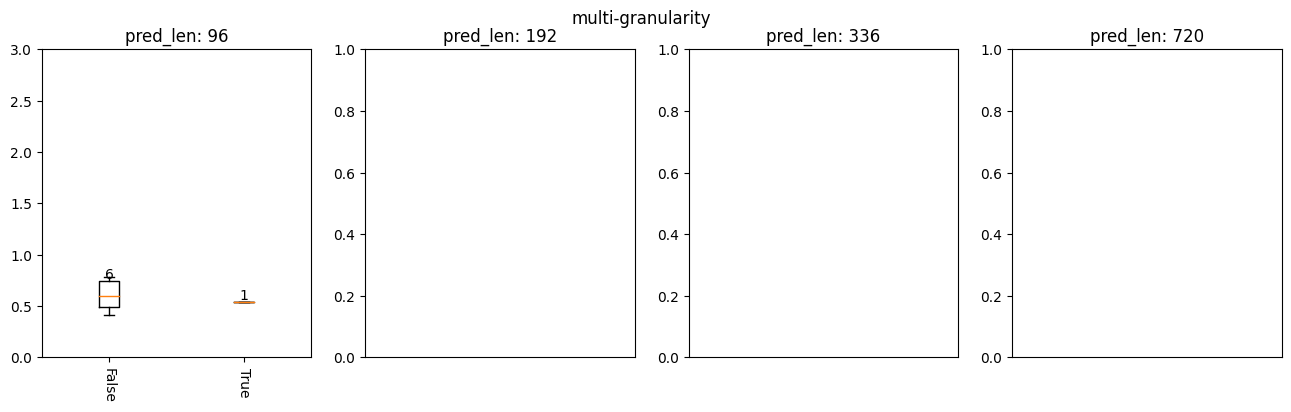

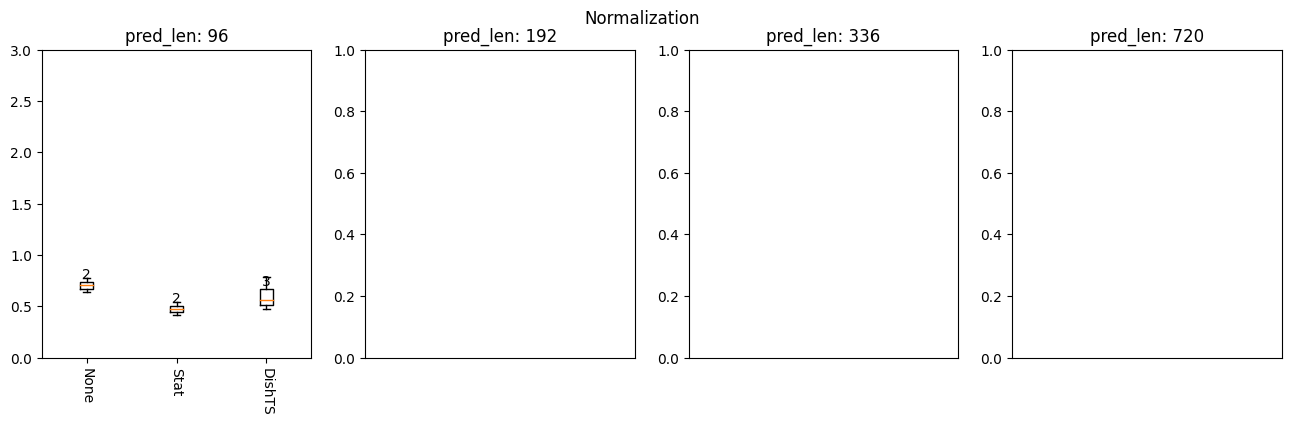

KeyboardInterrupt: 

In [40]:
# todo: NaN values?
intros = ['multi-granularity', 'Normalization', 'Decomposition', 'Channel-independent',
           'Tokenization', 'Backbone', 'Attention', 'Encoder-only',
             'Sequence Length', 'd_model', 'd_ff', 'Encoder layers', 'Training Epochs', 'Learning Rate']
for n, intro in enumerate(intros):
    fig = plt.figure(figsize=(16, 4))
    for i, pred_len in enumerate(pred_lens):
        result_dict_vis_comp = {}
        fig.add_subplot(1, 4, i+1)
        for j, comp in enumerate(set([_.split('_')[n] for _ in result_dict_vis[pred_len].keys()])):
            result_dict_vis_comp[comp] = {k:v for k, v in result_dict_vis[pred_len].items() if k.split('_')[n] == comp}
            v = np.array(list(result_dict_vis_comp[comp].values()))
            v = v[~np.isnan(v)]
            v = v[v < 1e+4] # todo: 为什么有mse溢出的情况?

            plt.boxplot(v, positions=[j])
            plt.text(j, np.quantile(v, 0.75), str(len(v)), ha='center', va='bottom')
            plt.ylim(0.0, 3.0)

        plt.xticks(range(len(result_dict_vis_comp)), result_dict_vis_comp.keys(), rotation=-90)
        plt.title(f'pred_len: {pred_len}')

    fig.suptitle(intro)
    plt.show()